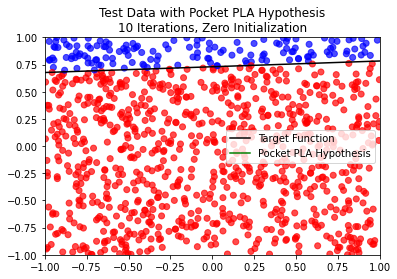

(a) Inicializando com 0, i = 10; N1 = 100; N2 = 1000.
  Média de E_in: 0.17441000000000004
  Desvio padrão de E_in: 0.050486155528025704
  Média de E_out: 0.114023
  Desvio padrão de E_out: 0.06775667104425954



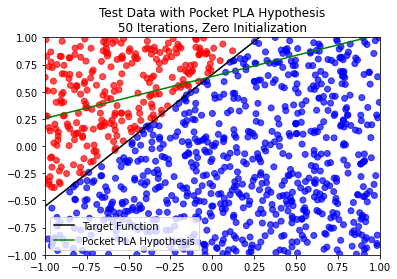

(b) Inicializando com 0, i = 50; N1 = 100; N2 = 1000.
  Média de E_in: 0.12744000000000003
  Desvio padrão de E_in: 0.02524770088542717
  Média de E_out: 0.058814000000000005
  Desvio padrão de E_out: 0.03851749477834715



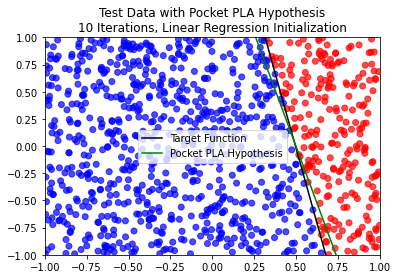

(c) Inicializando com Regressão Linear, i = 10; N1 = 100; N2 = 1000.
  Média de E_in: 0.13075
  Desvio padrão de E_in: 0.024036170660069793
  Média de E_out: 0.057222999999999996
  Desvio padrão de E_out: 0.032560854887425786



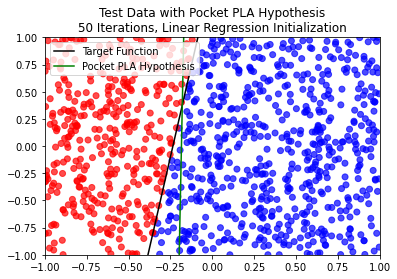

(d) Inicializando com Regressão Linear, i = 50; N1 = 100; N2 = 1000.
  Média de E_in: 0.11921000000000002
  Desvio padrão de E_in: 0.01962844619423555
  Média de E_out: 0.045720000000000004
  Desvio padrão de E_out: 0.029613368602710497



In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Função para gerar a função target
def generate_target_function():
    points = np.random.uniform(-1, 1, (2, 2))
    a = points[1, 1] - points[0, 1]
    b = points[0, 0] - points[1, 0]
    c = points[1, 0] * points[0, 1] - points[0, 0] * points[1, 1]
    return a, b, c

# Função target
def target_function(a, b, c, x):
    return np.sign(a * x[:, 0] + b * x[:, 1] + c)

# Gerar dados
def generate_data(N, a, b, c, noise_ratio=0.0):
    X = np.random.uniform(-1, 1, (N, 2))
    y = target_function(a, b, c, X)
    if noise_ratio > 0:
        num_noisy_points = int(N * noise_ratio)
        noisy_indices = np.random.choice(N, num_noisy_points, replace=False)
        y[noisy_indices] = -y[noisy_indices]
    return X, y

# Regressão Linear
def linear_regression(X, y):
    X_b = np.c_[np.ones((X.shape[0], 1)), X]
    w = np.linalg.pinv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)
    return w

# Pocket PLA
def pocket_pla(X, y, w_init, max_iterations):
    X_b = np.c_[np.ones((X.shape[0], 1)), X]
    w_pocket = w_init
    best_error = np.mean(np.sign(X_b.dot(w_init)) != y)
    w = w_init.copy()
    for _ in range(max_iterations):
        predictions = np.sign(X_b.dot(w))
        misclassified = np.where(predictions != y)[0]
        if len(misclassified) == 0:
            break
        idx = np.random.choice(misclassified)
        w += y[idx] * X_b[idx]
        current_error = np.mean(np.sign(X_b.dot(w)) != y)
        if current_error < best_error:
            best_error = current_error
            w_pocket = w.copy()
    return w_pocket, best_error

# Calcular erro dentro e fora da amostra
def calculate_error(X, y, w):
    X_b = np.c_[np.ones((X.shape[0], 1)), X]
    predictions = np.sign(X_b.dot(w))
    return np.mean(predictions != y)

# Função para plotar resultados
def plot_results(X, y, w, a, b, c, title):
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap='bwr', alpha=0.7)
    x_vals = np.linspace(-1, 1, 100)
    plt.plot(x_vals, -(a / b) * x_vals - c / b, 'k-', label='Target Function')
    plt.plot(x_vals, -(w[1] / w[2]) * x_vals - w[0] / w[2], 'g-', label='Pocket PLA Hypothesis')
    plt.title(title)
    plt.xlim([-1, 1])
    plt.ylim([-1, 1])
    plt.legend()
    plt.show()

# Experimento
def experiment(num_runs, num_points_train, num_points_test, max_iterations, initialize_with_linear_regression):
    ein_list = []
    eout_list = []

    for _ in range(num_runs):
        a, b, c = generate_target_function()
        X_train, y_train = generate_data(num_points_train, a, b, c, noise_ratio=0.1)
        
        if initialize_with_linear_regression:
            w_init = linear_regression(X_train, y_train)
        else:
            w_init = np.zeros(X_train.shape[1] + 1)

        w_pocket, ein = pocket_pla(X_train, y_train, w_init, max_iterations)

        X_test, y_test = generate_data(num_points_test, a, b, c)
        eout = calculate_error(X_test, y_test, w_pocket)

        ein_list.append(ein)
        eout_list.append(eout)

        if _ == 0:  # Plotar apenas o primeiro caso como exemplo
            plot_results(X_test, y_test, w_pocket, a, b, c, f'Test Data with Pocket PLA Hypothesis\n{max_iterations} Iterations, {"Linear Regression" if initialize_with_linear_regression else "Zero"} Initialization')

    return np.mean(ein_list), np.std(ein_list), np.mean(eout_list), np.std(eout_list)

# Parâmetros
num_runs = 1000
num_points_train = 100
num_points_test = 1000

# Executar experimentos para os diferentes casos
cases = [
    {"description": "(a) Inicializando com 0, i = 10; N1 = 100; N2 = 1000.", "max_iterations": 10, "initialize_with_linear_regression": False},
    {"description": "(b) Inicializando com 0, i = 50; N1 = 100; N2 = 1000.", "max_iterations": 50, "initialize_with_linear_regression": False},
    {"description": "(c) Inicializando com Regressão Linear, i = 10; N1 = 100; N2 = 1000.", "max_iterations": 10, "initialize_with_linear_regression": True},
    {"description": "(d) Inicializando com Regressão Linear, i = 50; N1 = 100; N2 = 1000.", "max_iterations": 50, "initialize_with_linear_regression": True},
]

for case in cases:
    mean_ein, std_ein, mean_eout, std_eout = experiment(num_runs, num_points_train, num_points_test, case["max_iterations"], case["initialize_with_linear_regression"])
    print(f"{case['description']}")
    print(f"  Média de E_in: {mean_ein}")
    print(f"  Desvio padrão de E_in: {std_ein}")
    print(f"  Média de E_out: {mean_eout}")
    print(f"  Desvio padrão de E_out: {std_eout}\n")
